## Проект спринт 12
**Название проекта**:  
Цифра     
_____
**Описание исследования**:  
Построение модели предсказания коэффициента восстановления золота из золотосодержащей руды на основании данных с параметрами добычи и очистки.  
_____
**Цель исследования**:  
Оптимизация производства, чтобы не запускать предприятие с убыточными характеристиками.
_____
**План исследования.**  
[Шаг 1. Загрузка и подготовка данных](#step1)  
[Шаг 2. Анализ данных](#step2)  
[Шаг 3. Построение модели](#step3)  
[Шаг 4. Результаты и выводы](#step4)  
_____
**Исходные данные.**
Исходные файлы, содержащие данные геологоразведки трёх регионов:  
- [gold_recovery_full_new.csv](gold_recovery_full_new.csv) - полные исходные данные
- [gold_recovery_test_new.csv](gold_recovery_test_new.csv) - валидационная выборка
- [gold_recovery_train_new.csv](gold_recovery_train_new.csv) - обучающая выборка   


<a id='step1'></a>
## Шаг 1. Загрузка и подготовка данных

In [71]:
# загружаем нужные библиотеки
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
RANDOM_STATE = 54321
CROSS_VALS = 3

### Откроем файлы и изучим их

In [72]:
def load_file(file_name):
    try:
        df = pd.read_csv(file_name)
        print('Загрузили файл локально')
    except:
        file_path = 'https://code.s3.yandex.net/datasets/' + file_name
        print('локально не удалось, загружаем из интернета')
        df = pd.read_csv(file_path)
    return df

In [73]:
full = load_file('gold_recovery_full_new.csv')
test = load_file('gold_recovery_test_new.csv')
train = load_file('gold_recovery_train_new.csv')
print(full.shape)
print(train.shape)
print(test.shape)

Загрузили файл локально
Загрузили файл локально
Загрузили файл локально
(19439, 87)
(14149, 87)
(5290, 53)


в тестовом датасете меньше фичей, чем в полной и обучающих выборках

In [74]:
display(train.sample(2))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4973,2017-01-19 01:59:59,9.097971,10.707065,14.037618,38.442434,71.812864,8.494405,2.630733,8.699028,2.719675,...,13.985820,-502.083444,13.862246,-500.116643,13.740728,-502.161402,7.983539,-500.277482,20.015492,-600.686090
12375,2018-05-21 23:59:59,4.483694,10.716824,6.973968,44.908446,67.723366,9.504985,2.482157,9.359607,3.165193,...,29.999089,-499.468418,19.936419,-499.576912,17.956604,-499.504873,13.978691,-499.936354,14.023750,-499.810209


In [75]:
print(train.columns)

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

### Проверим, что эффективность обогащения рассчитана правильно

In [76]:
# C (F - T)
# F (C - T)
# C - Au after
# F - Au before
# T - Au in tails
train['rougher.output.recovery_calc'] = 100.0 * train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au']) / (train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))
m = mae(train['rougher.output.recovery'], train['rougher.output.recovery_calc'])
print(m)

1.1498046842860452e-14


на тестовой выборке разница MAE между рассчитанным уровнем обогащения и из данных ничтожно мал, можно рассчитывать на исходные данные

### Проанализируем признаки, недоступные в тестовой выборке

In [77]:
test_columns = set(test.columns)
train_columns = set(train.columns)
diff = list(sorted(train_columns - test_columns))
diff

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_calc',
 'rougher.output.tail_ag',
 'rougher.out

In [78]:
display(train[diff].info())
display(train[diff].sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_au                         14149 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_au                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_ag,final.output.tail_au,final.output.tail_pb,final.output.tail_sol,primary_cleaner.output.concentrate_ag,...,rougher.output.recovery,rougher.output.recovery_calc,rougher.output.tail_ag,rougher.output.tail_au,rougher.output.tail_pb,rougher.output.tail_sol,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol
448,10.910508,36.163306,8.184738,9.902419,48.676648,10.863813,3.434780,1.857393,14.810387,12.124105,...,81.888186,81.888186,5.182528,1.560346,0.432482,21.262734,11.619873,7.530912,5.198571,11.855547
837,6.060497,41.010198,11.620549,11.251280,77.106476,13.372926,3.302167,2.419027,8.586122,10.145571,...,93.391582,93.391582,5.465968,1.536519,0.252385,11.619579,15.205438,3.498258,4.870953,11.055681
5343,6.832572,42.410829,12.209045,14.992795,65.788085,10.010459,4.034691,4.164755,8.229136,10.646077,...,90.375816,90.375816,5.425959,1.574131,0.364924,11.976142,13.611804,3.558502,5.488047,6.376373
2799,3.912074,46.022468,9.570609,8.454984,63.935109,7.643303,2.652796,1.892044,10.645261,6.352597,...,74.791184,74.791184,5.905128,2.115652,0.685898,14.492964,13.993732,4.877583,4.693870,11.676106
5545,6.744616,44.418678,9.337946,15.386655,63.975268,11.339667,4.333018,3.388649,12.082838,10.231615,...,87.457294,87.457294,7.494232,2.149922,0.671373,19.207179,16.069501,4.483454,3.491851,14.932928
2507,4.463826,46.661348,8.272228,11.177797,69.669473,11.226362,3.123345,1.914995,11.843815,6.721578,...,83.213677,83.213677,7.195346,2.268162,0.467251,18.717804,14.999267,4.301668,3.123284,10.559351
587,6.165558,40.689949,11.590047,4.282350,63.825656,10.752349,2.561514,1.237601,15.904118,9.403720,...,74.617585,74.617585,5.808488,2.107087,0.845866,19.015582,12.787766,2.740324,4.505242,10.133104
8406,4.887031,44.665390,11.163725,6.321348,62.237356,7.652717,2.749770,2.508879,8.872532,6.961509,...,80.322360,80.322360,5.755375,1.707593,0.521871,16.626450,16.044785,6.466233,7.747450,2.115402
5390,5.834554,44.183017,10.813026,13.250241,72.473781,10.384479,3.183235,4.068563,7.865101,9.117297,...,88.981968,88.981968,5.567539,1.700360,0.413998,11.502357,14.560916,2.175706,5.456290,7.368219
13418,3.858077,47.310821,10.537449,6.709347,73.877335,11.566860,1.975452,3.395200,4.624560,6.060676,...,87.701837,87.701837,5.107551,1.168599,0.375986,10.989301,17.563045,2.769973,11.462484,NaN


в тестовой выборке отсутствуют почти все данные о выходе и хвостах на всех этапах процесса очистки (кроме выхода из вторичной очистки, которая есть)  
также отсутствуют некоторые расчетные данные: `rougher.calculation.au_pb_ratio`, `rougher.calculation.floatbank10_sulfate_to_au_feed`, `rougher.calculation.floatbank11_sulfate_to_au_feed`, `rougher.calculation.sulfate_to_au_concentrate`

### проведем предобработку данных

In [79]:
# уберем из train поля, которых нет в test (кроме целевых переменных)
target_columns = ['rougher.output.recovery', 'final.output.recovery']
target_date_columns = ['rougher.output.recovery', 'final.output.recovery', 'date']
diff = set(diff)
diff = list(diff - set(target_columns))

train.drop(diff, axis='columns', inplace=True)

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   final.output.recovery                       14149 non-null  float64
 2   primary_cleaner.input.sulfate               14129 non-null  float64
 3   primary_cleaner.input.depressant            14117 non-null  float64
 4   primary_cleaner.input.feed_size             14149 non-null  float64
 5   primary_cleaner.input.xanthate              14049 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 10  primary_cl

In [81]:
train.sample(10)

,date,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
13946,2018-08-09 07:59:59,81.451530,140.229929,10.024438,6.720,1.011831,1652.431287,-400.232868,1651.116866,-400.650560,...,26.992233,-502.319378,23.059940,-499.807082,22.982987,-499.684900,17.988209,-499.956800,23.004334,-523.495317
3315,2016-06-27 17:59:59,67.960530,104.625297,4.577729,8.200,1.189888,1701.623977,-499.620080,1700.325229,-498.813600,...,16.994554,-500.109890,9.050145,-499.500925,16.998980,-499.515059,7.943316,-499.411727,25.008620,-500.767786
2467,2016-05-20 18:59:59,60.285343,162.399609,16.698106,7.770,0.444683,1198.873131,-548.623748,1201.226370,-549.163316,...,10.003816,-499.712859,8.004546,-499.344903,8.965785,-550.605197,5.947994,-550.458453,19.976371,-599.659789
3258,2016-06-25 08:59:59,67.135216,106.236740,5.069156,7.639,1.204916,1598.522014,-499.248767,1599.168382,-498.859623,...,16.014287,-500.699726,8.130134,-499.273764,16.018004,-499.859636,6.964003,-500.122748,24.967439,-501.766856
11917,2018-04-29 06:59:59,73.051656,209.763119,9.970973,7.130,1.048477,1703.150958,-499.926072,1706.100945,-497.847938,...,26.968563,-503.843216,20.113074,-499.504684,19.963101,-502.032139,15.029199,-499.979748,18.013611,-500.440499
7877,2017-06-09 16:59:59,61.625153,97.575016,12.037138,7.350,0.989336,1698.597626,-499.108810,1700.255036,-499.711361,...,14.998882,-498.306591,9.953945,-379.185868,14.993839,-499.395612,10.001948,-499.924258,15.009961,-498.951631
10868,2018-03-09 06:59:59,76.287576,143.989155,8.008279,7.510,1.804493,1700.746965,-500.348720,1669.949906,-500.565958,...,22.967520,-499.317633,14.996776,-499.921402,17.996439,-499.748866,11.990962,-500.057355,11.980319,-500.295425
3236,2016-06-24 10:59:59,64.749584,108.835136,5.009719,7.710,1.047040,1601.781075,-499.654213,1598.233416,-499.793290,...,16.001737,-498.972003,7.945450,-490.744955,15.969948,-497.570939,6.995101,-498.675607,24.965784,-495.177795
7465,2017-05-18 17:59:59,59.362563,71.419321,6.026063,6.650,0.495187,1651.966239,-500.867283,1750.099607,-501.812978,...,25.022513,-398.007907,23.006599,-399.107157,26.015884,-448.606260,20.068778,-449.795326,30.040699,-499.444899
2412,2016-05-18 11:59:59,67.904537,160.199436,16.554750,8.020,0.703047,1199.100214,-550.833070,1200.557348,-550.585395,...,9.999954,-499.797447,7.997385,-501.112599,9.017304,-552.779173,6.022940,-550.845277,20.029184,-502.261465


In [82]:
train['date'] = pd.to_datetime(train.date, format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test.date, format='%Y-%m-%d %H:%M:%S')
full['date'] = pd.to_datetime(full.date, format='%Y-%m-%d %H:%M:%S')

In [83]:
train.dropna(inplace=True)

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12679 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        12679 non-null  datetime64[ns]
 1   final.output.recovery                       12679 non-null  float64       
 2   primary_cleaner.input.sulfate               12679 non-null  float64       
 3   primary_cleaner.input.depressant            12679 non-null  float64       
 4   primary_cleaner.input.feed_size             12679 non-null  float64       
 5   primary_cleaner.input.xanthate              12679 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      12679 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    12679 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_air      12679 non-null  float64       
 9   primar

### построим распределения переменных в обучающих и тестовых выборках на одних графиках

date


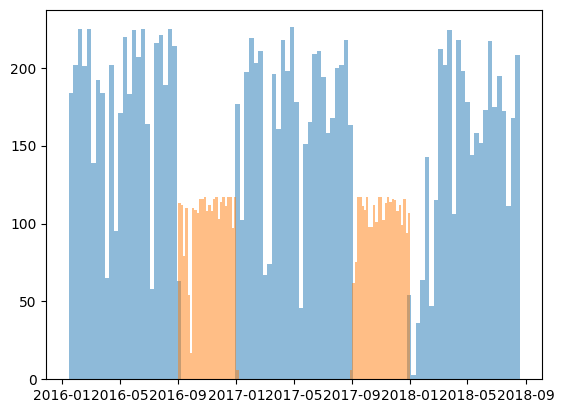

final.output.recovery


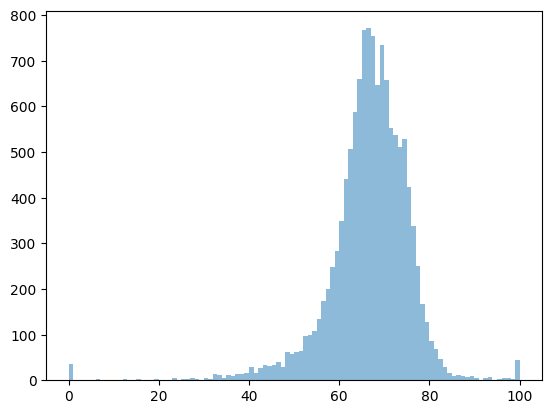

primary_cleaner.input.sulfate


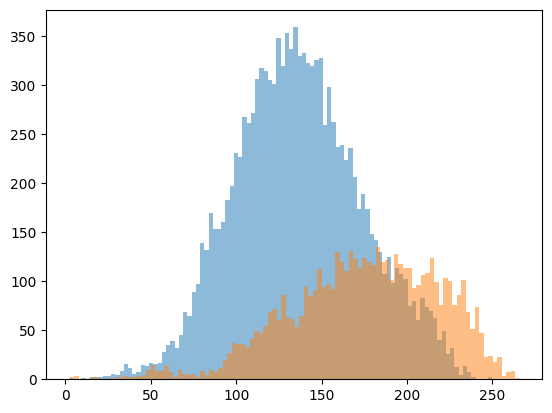

primary_cleaner.input.depressant


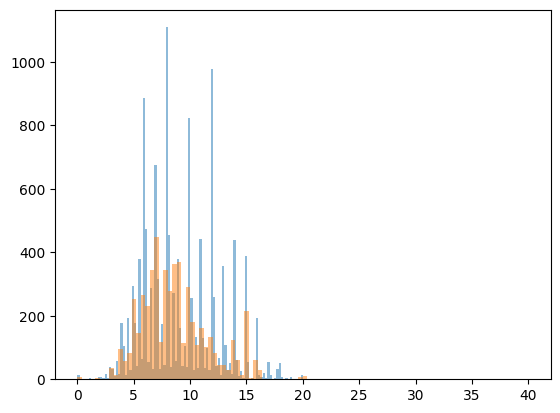

primary_cleaner.input.feed_size


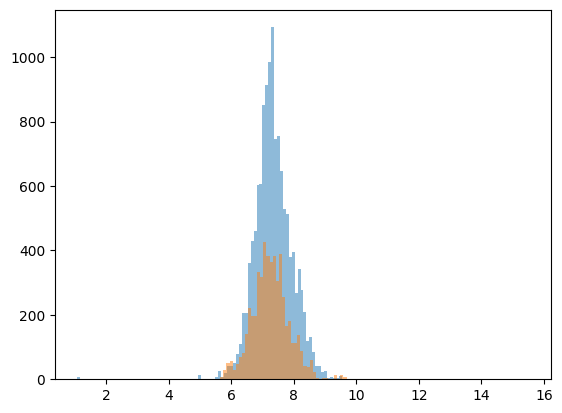

primary_cleaner.input.xanthate


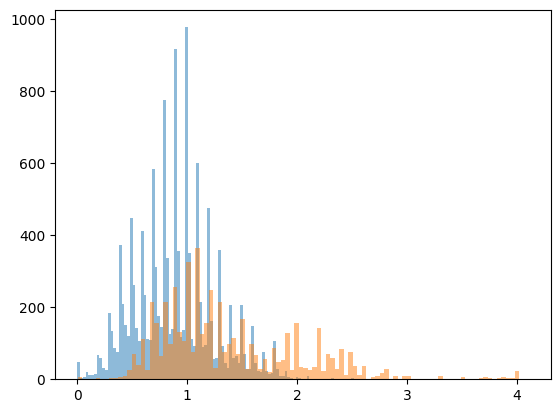

primary_cleaner.state.floatbank8_a_air


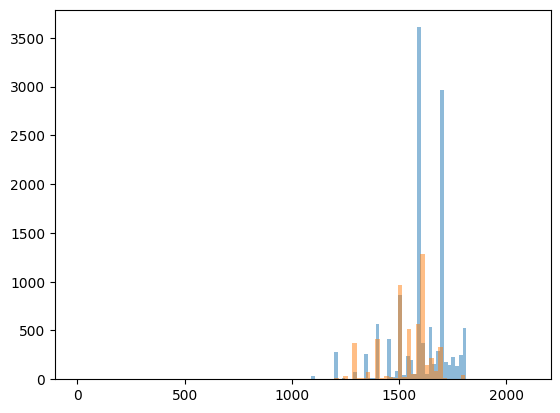

primary_cleaner.state.floatbank8_a_level


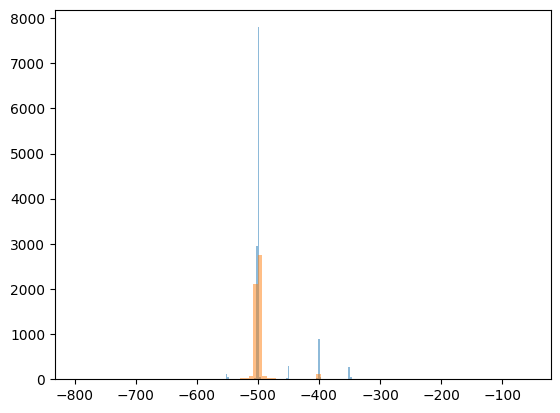

primary_cleaner.state.floatbank8_b_air


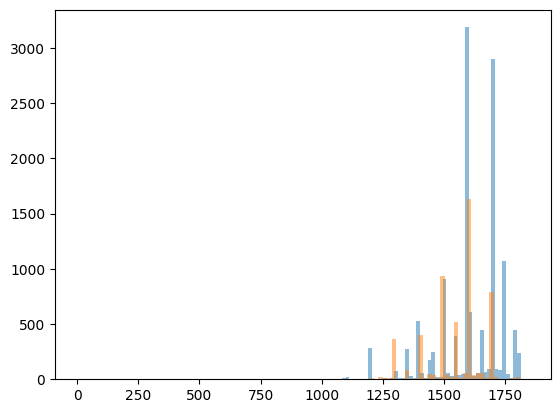

primary_cleaner.state.floatbank8_b_level


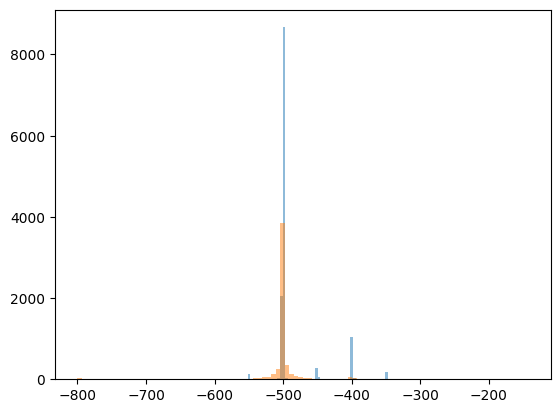

primary_cleaner.state.floatbank8_c_air


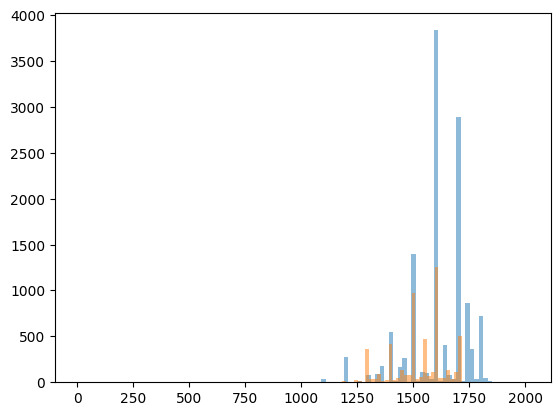

primary_cleaner.state.floatbank8_c_level


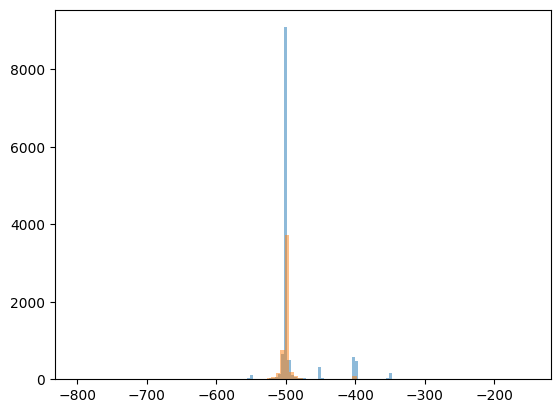

primary_cleaner.state.floatbank8_d_air


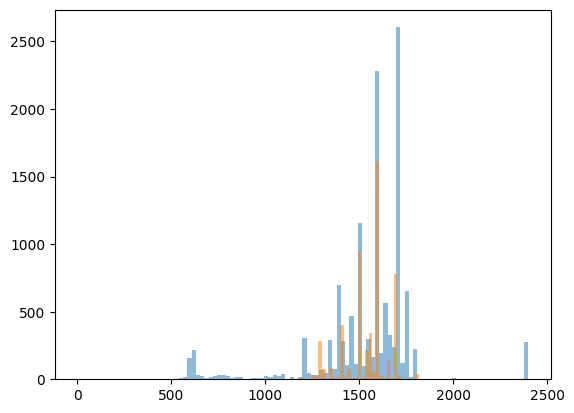

primary_cleaner.state.floatbank8_d_level


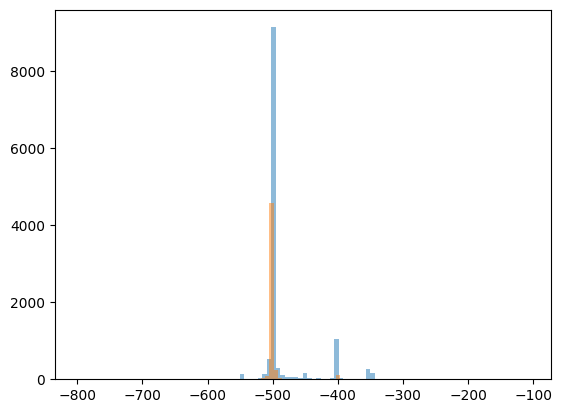

rougher.input.feed_ag


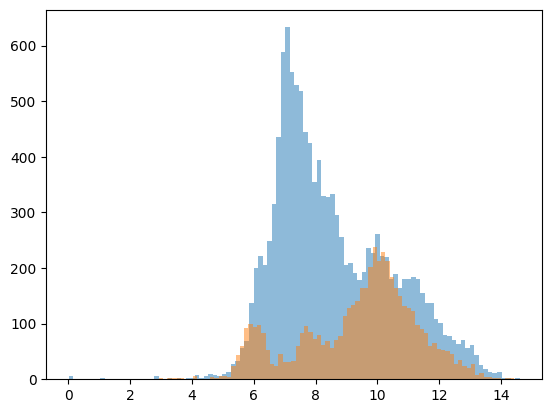

rougher.input.feed_pb


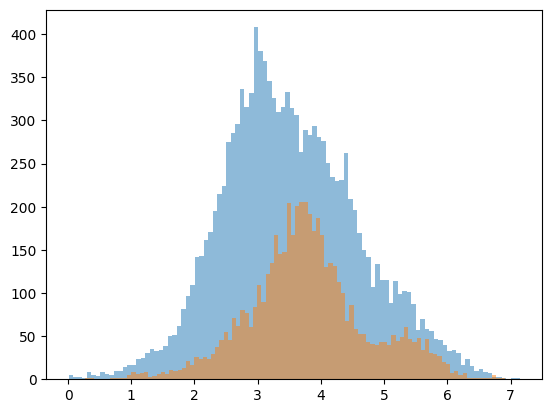

rougher.input.feed_rate


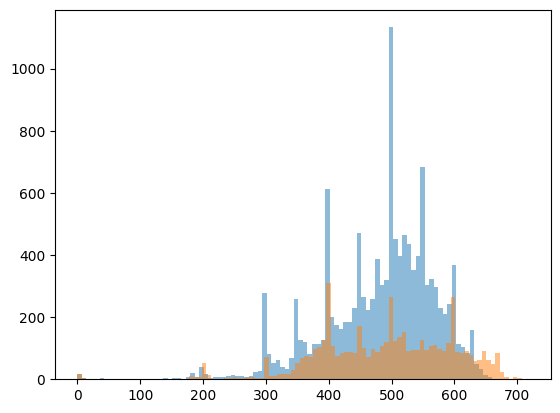

rougher.input.feed_size


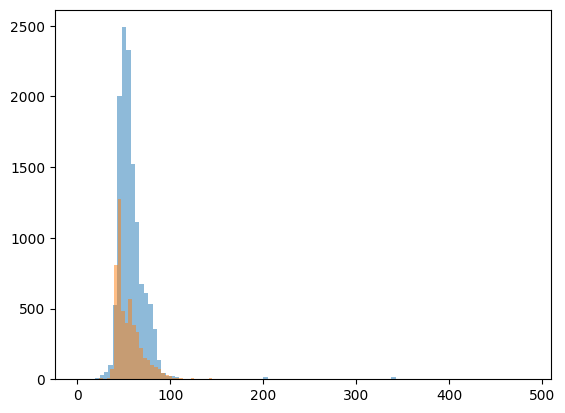

rougher.input.feed_sol


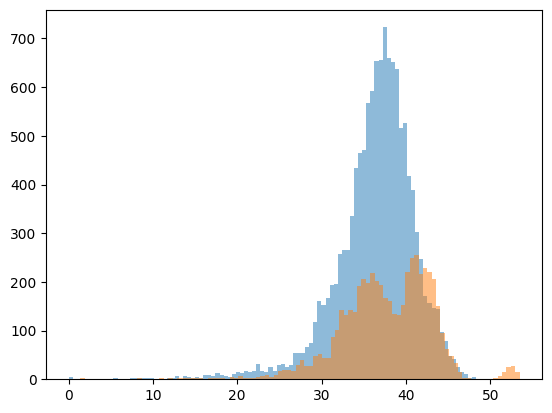

rougher.input.feed_au


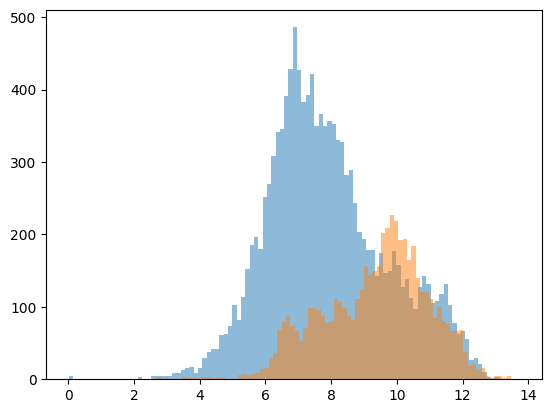

rougher.input.floatbank10_sulfate


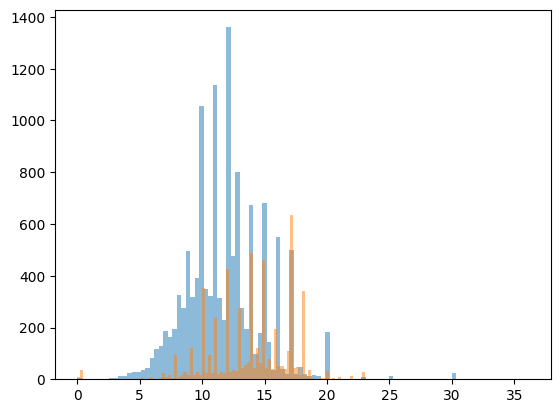

rougher.input.floatbank10_xanthate


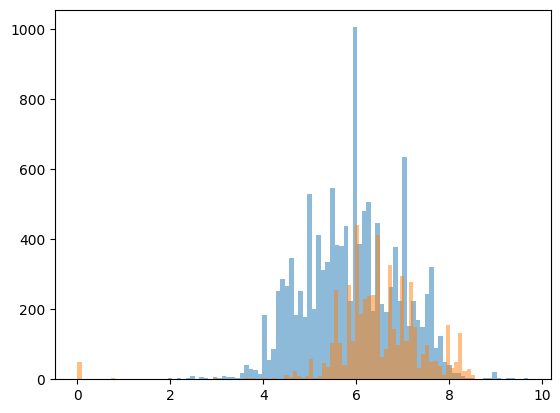

rougher.input.floatbank11_sulfate


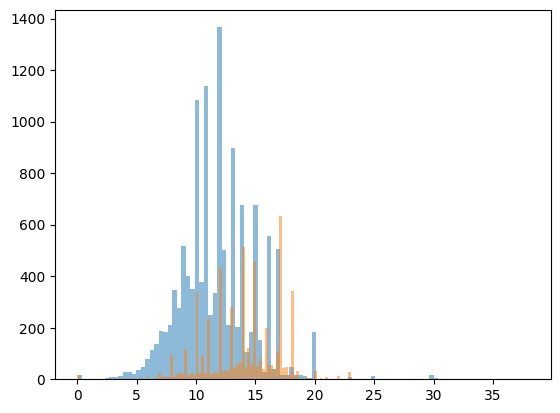

rougher.input.floatbank11_xanthate


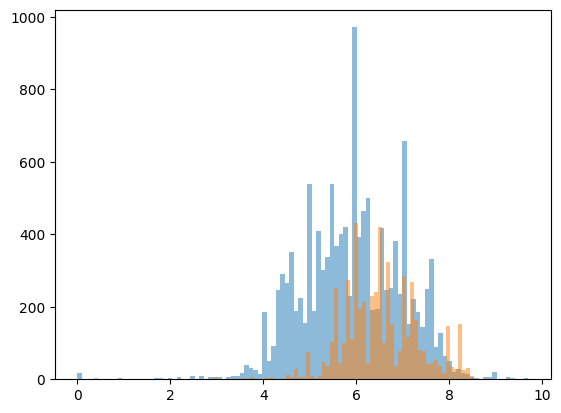

rougher.output.recovery


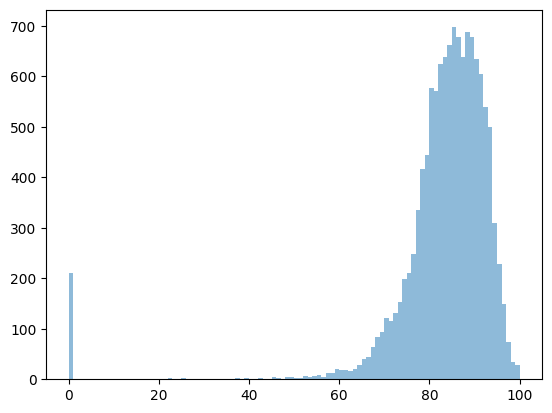

rougher.state.floatbank10_a_air


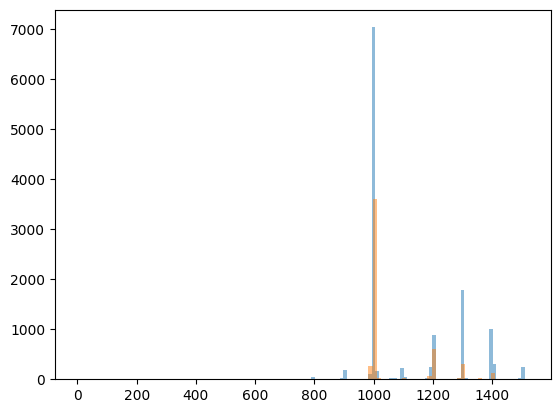

rougher.state.floatbank10_a_level


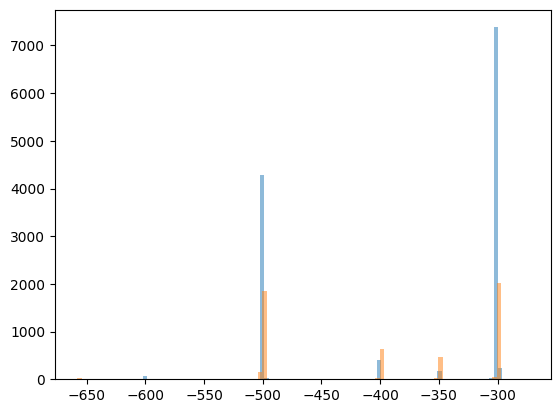

rougher.state.floatbank10_b_air


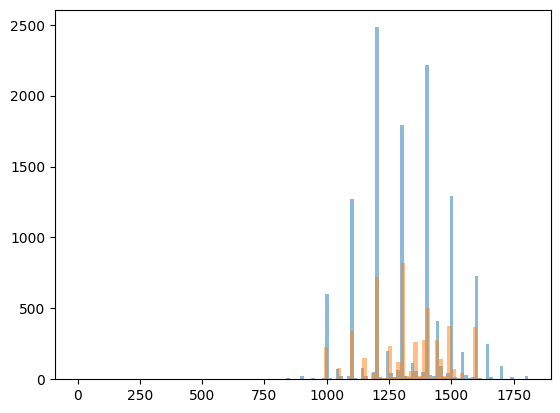

rougher.state.floatbank10_b_level


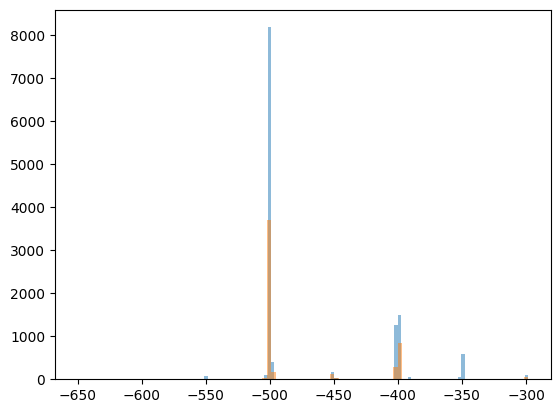

rougher.state.floatbank10_c_air


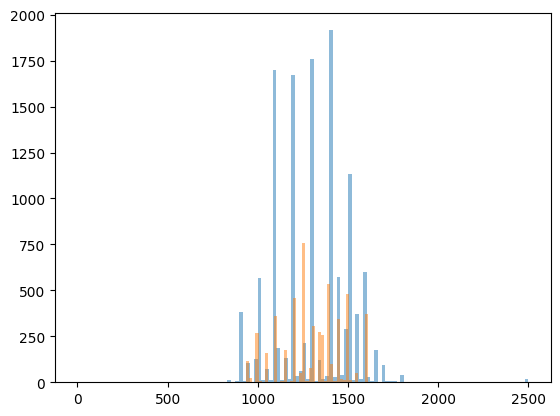

rougher.state.floatbank10_c_level


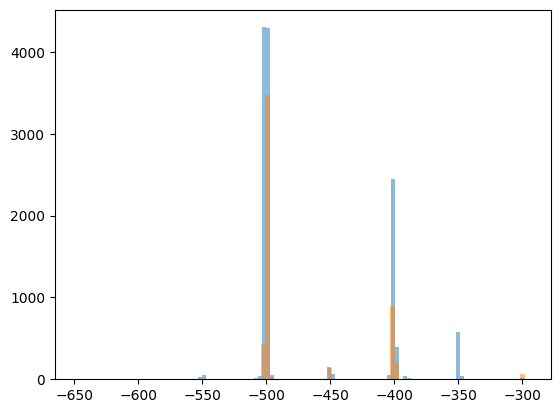

rougher.state.floatbank10_d_air


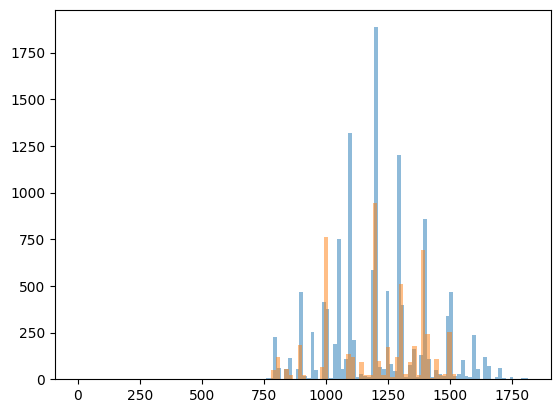

rougher.state.floatbank10_d_level


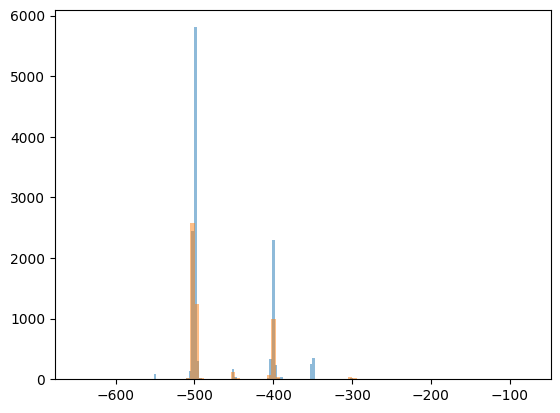

rougher.state.floatbank10_e_air


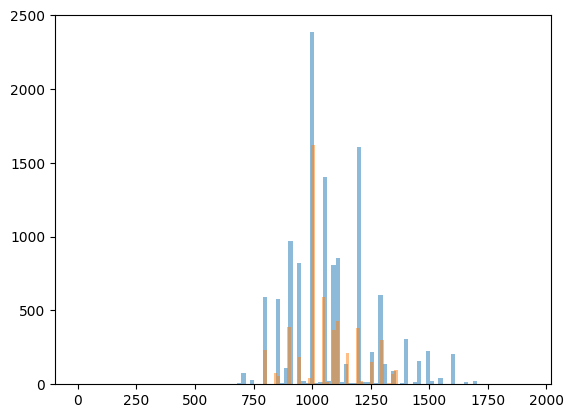

rougher.state.floatbank10_e_level


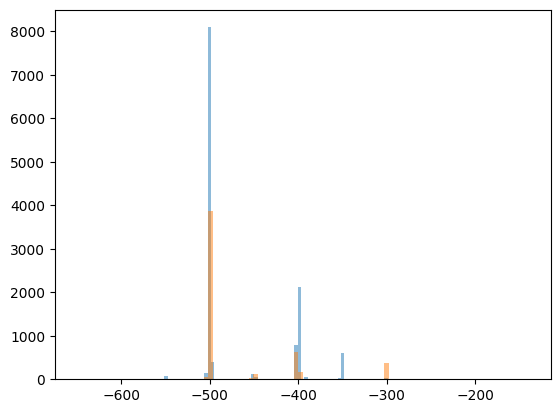

rougher.state.floatbank10_f_air


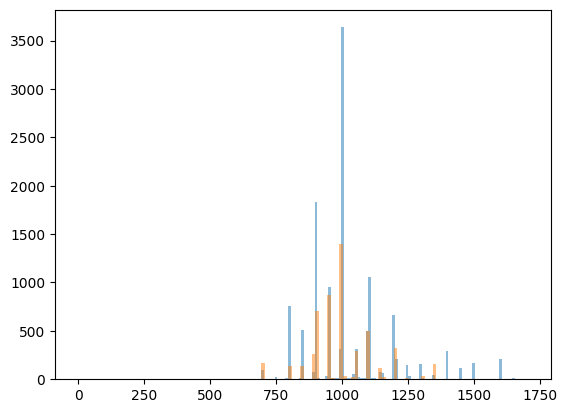

rougher.state.floatbank10_f_level


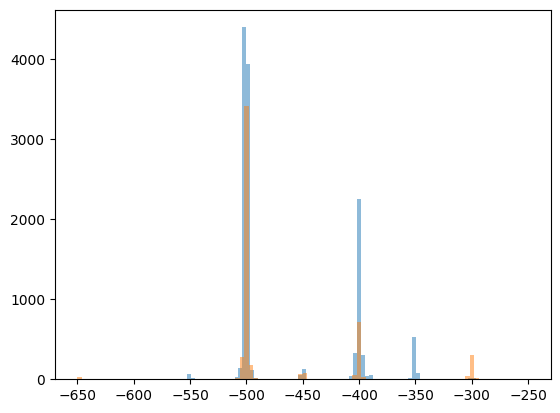

secondary_cleaner.state.floatbank2_a_air


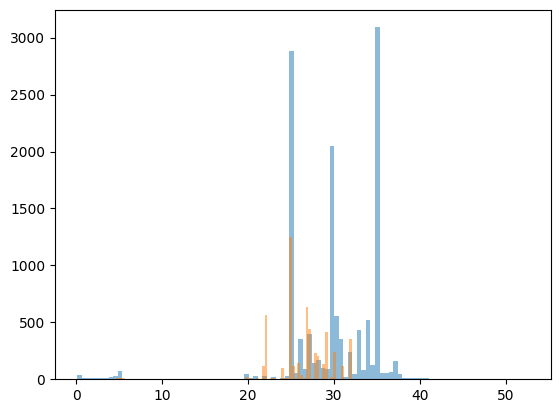

secondary_cleaner.state.floatbank2_a_level


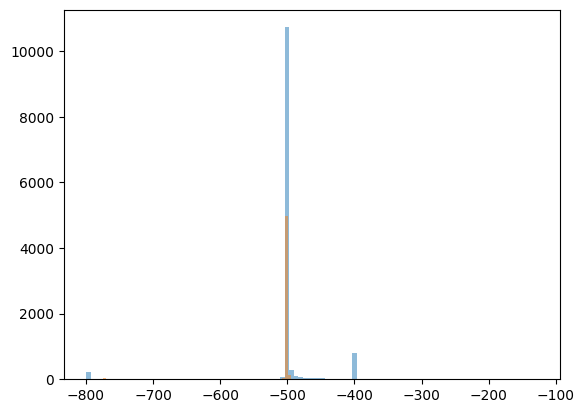

secondary_cleaner.state.floatbank2_b_air


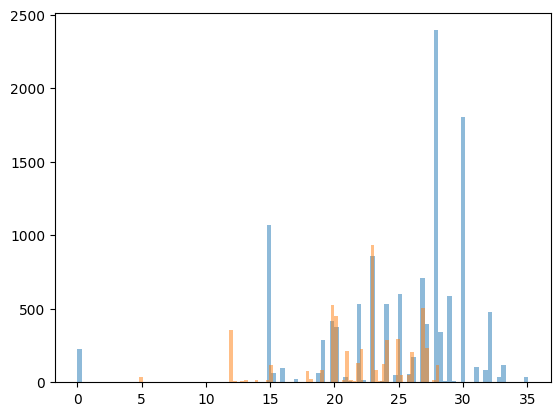

secondary_cleaner.state.floatbank2_b_level


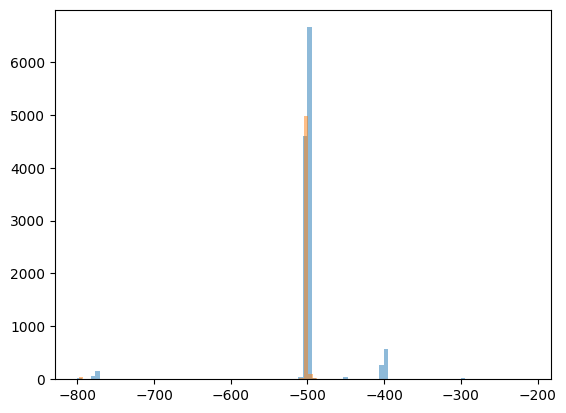

secondary_cleaner.state.floatbank3_a_air


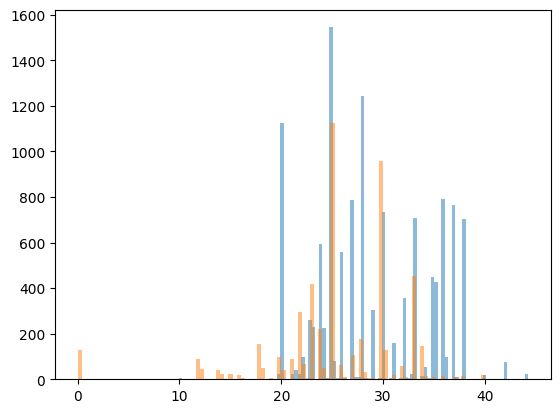

secondary_cleaner.state.floatbank3_a_level


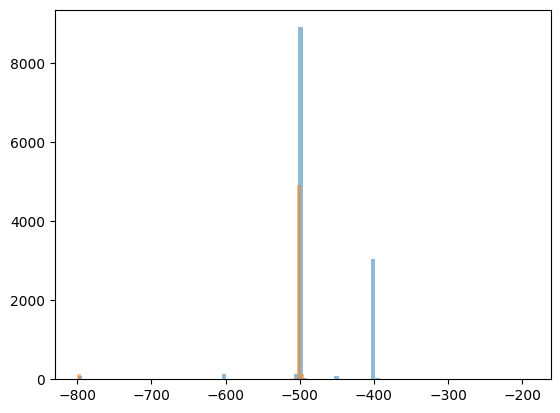

secondary_cleaner.state.floatbank3_b_air


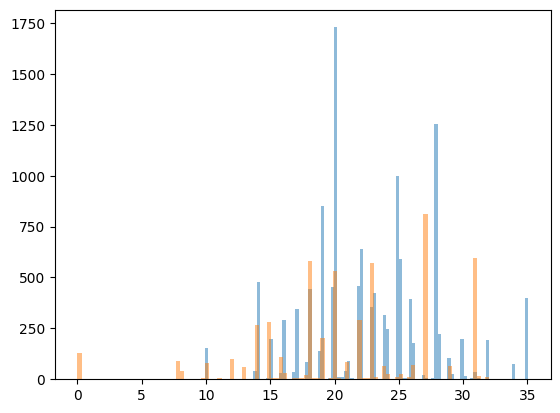

secondary_cleaner.state.floatbank3_b_level


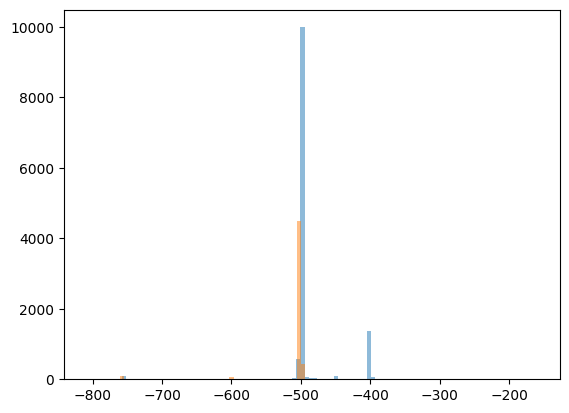

secondary_cleaner.state.floatbank4_a_air


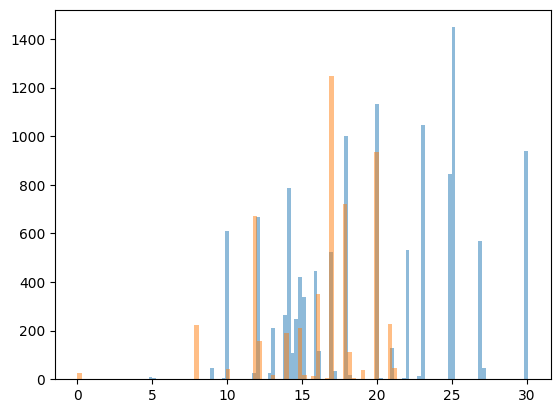

secondary_cleaner.state.floatbank4_a_level


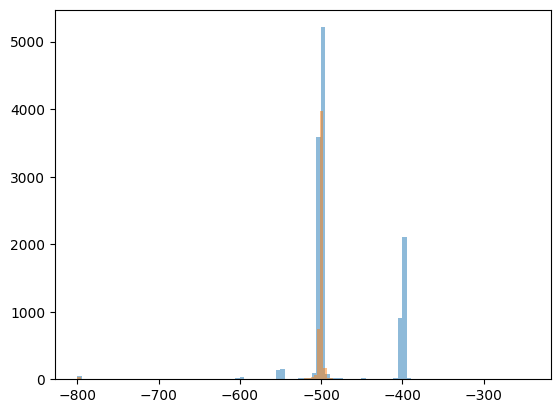

secondary_cleaner.state.floatbank4_b_air


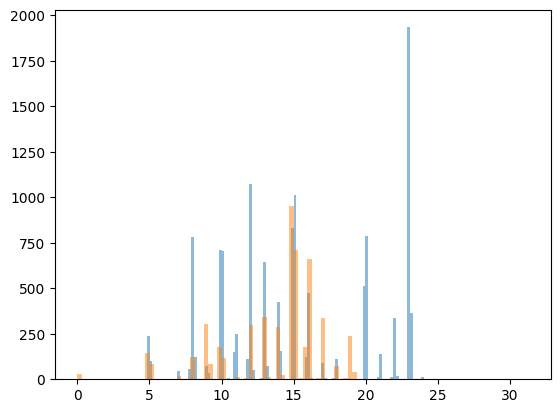

secondary_cleaner.state.floatbank4_b_level


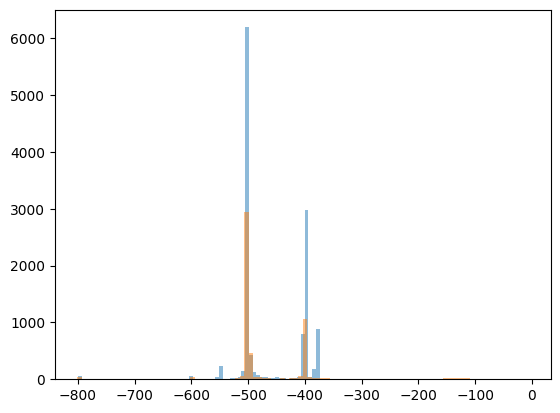

secondary_cleaner.state.floatbank5_a_air


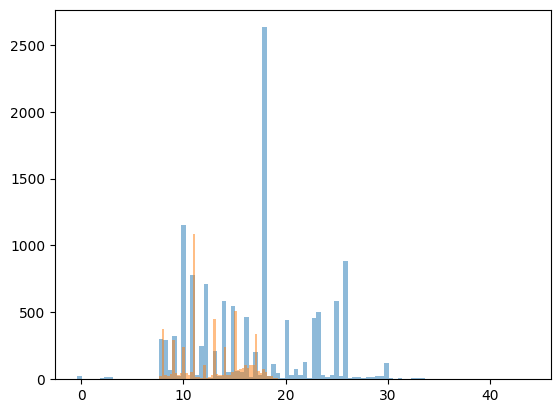

secondary_cleaner.state.floatbank5_a_level


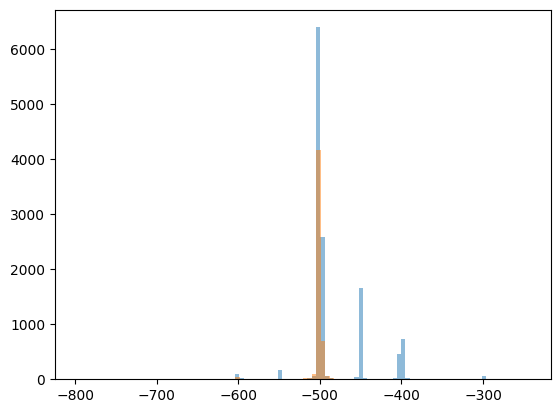

secondary_cleaner.state.floatbank5_b_air


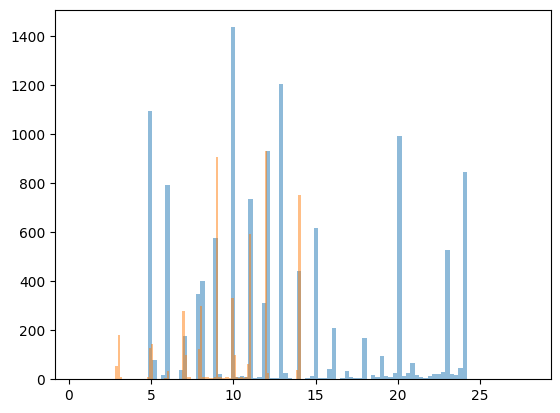

secondary_cleaner.state.floatbank5_b_level


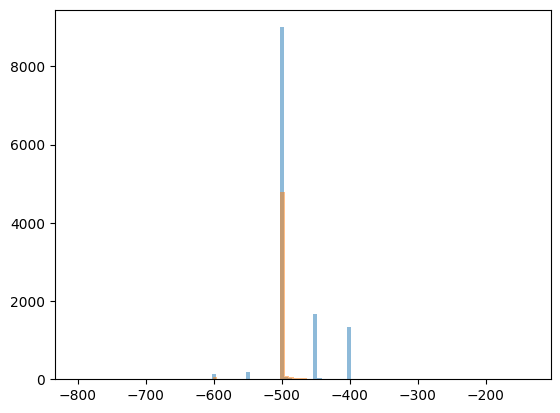

secondary_cleaner.state.floatbank6_a_air


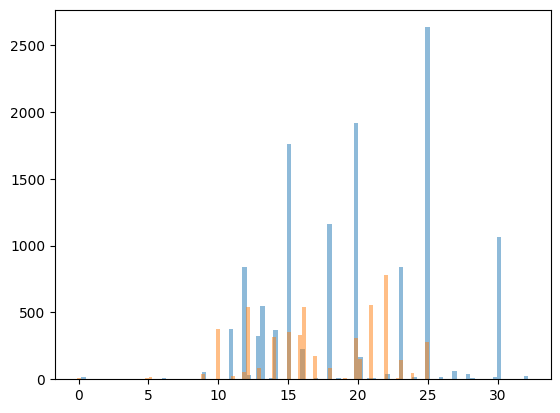

secondary_cleaner.state.floatbank6_a_level


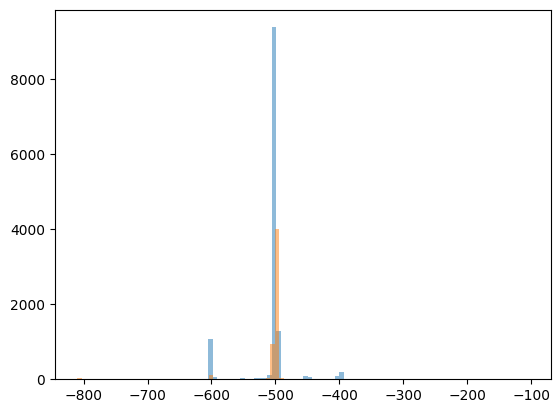

In [85]:
bins = 100
for i in train.columns:
    print(i)
    plt.hist(train[i], bins=bins, alpha=0.5)
    if i in test.columns:
        plt.hist(test[i], bins=bins, alpha=0.5)
    plt.show()

Основные выводы и расхождения:  
- для тестовой выборки взяли выбранные даты  
- в тестовой выборке распределения параметров не полностью повторяют распределение в обучающей выборке; как минимум, все данные кроме дат необходимо нормализовать перед обучением модели

<a id='step2'></a>
## Шаг 2. Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [86]:
full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [87]:
metals = ['au', 'ag', 'pb']
prefix_states = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
axis_states = ['в исходном сырье', 'после флотации', 'после первичной очистки', 'в финальном концентрате']

AU


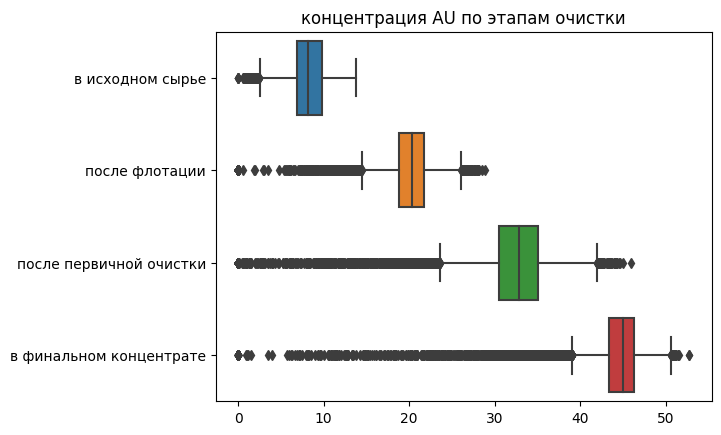

AG


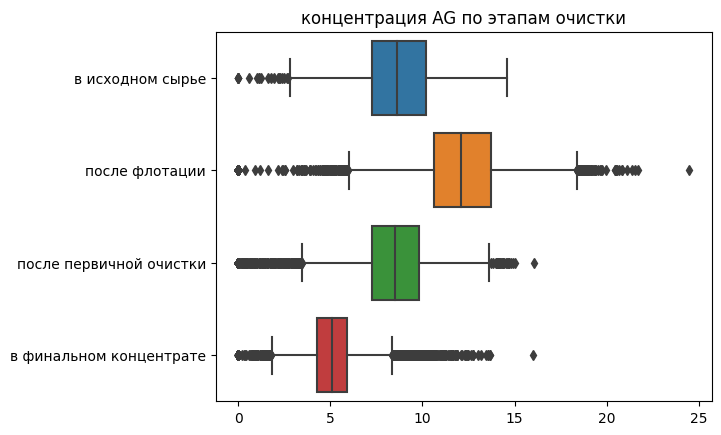

PB


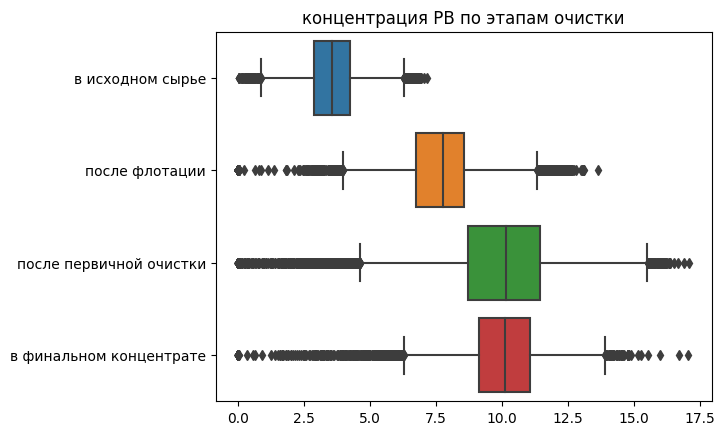

In [88]:
for metal in metals:
    p = []
    for i in range(len(prefix_states)):
        p.append(prefix_states[i] + metal)
    print(metal.upper())
    fig, ax = plt.subplots()
    _ = sns.boxplot(data=full[p], orient='h')
    ax.set_yticklabels(axis_states)
    plt.title(label=f'концентрация {metal.upper()} по этапам очистки')
    plt.show()

Концентрация золота в ходе процесса очистки стабильно растет, начиная с 10% до 50%  
Концентрация серебра вырастает после флотации с 9% до 13%, затем падает до 5% после финального этапа очистки  
Концентрпция свинца растет с 3% до 10% после первичной очистки и остается на этом уровне в финальном концентрате

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

In [89]:
train['rougher.input.feed_size'].describe()

count    12679.000000
mean        58.414412
std         20.441275
min          9.659576
25%         48.721041
50%         54.651129
75%         63.719220
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [90]:
test['rougher.input.feed_size'].describe()

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

<AxesSubplot:>

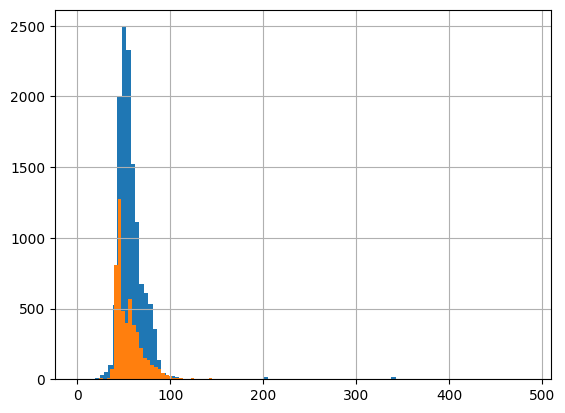

In [91]:
train['rougher.input.feed_size'].hist(bins=100)
test['rougher.input.feed_size'].hist(bins=100)

распределение размера гранул не являются одинаковыми на обучающей и тестовой выборках, но нормализации должно быть достаточно для обеспечения качественных предсказаний

### Исследуем суммарную концентрацию всех веществ на разных стадиях

In [92]:
rougher_feed = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']
rougher_au = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']
final_au = ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']

full['rougher_feed'] = full[rougher_feed].sum(axis=1)
full['rougher_au'] = full[rougher_au].sum(axis=1)
full['final_au'] = full[final_au].sum(axis=1)

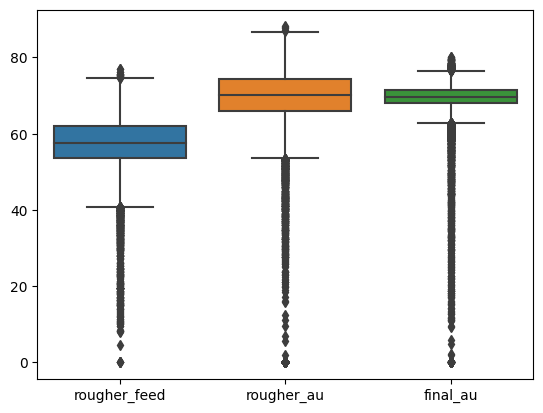

In [93]:
_ = sns.boxplot(data=full[['rougher_feed', 'rougher_au', 'final_au']])

после первичной очистки концентрация металлов в среднем повышается с 60% до 70%, при этом разброс значений достаточно велик  
после финальной очистки концентрация в среднем уже не повышается, но значительно снижается разброс цифр

<a id='step3'></a>
## Шаг 3. Построение модели

In [94]:
test.fillna(method='bfill', inplace=True)

функции для вычисления итоговой sMAPE

In [95]:
def sMAPE(y_true, y_pred):
    y_t = list(y_true)
    y_p = list(y_pred)
    sum_ = 0.0
    n = len(y_t)
    for i in range(n):
        nom = abs(y_t[i] - y_p[i])
        den = abs(y_t[i]) + abs(y_p[i])
        dt = nom / den
        sum_ += 2.0 * dt
    return 100.0 * sum_ / n

In [96]:
sMAPE_scorer = make_scorer(sMAPE, greater_is_better=False)

In [97]:
def sMAPEtotal_(sMAPErougher, sMAPEfinal):
    return 0.25 * sMAPErougher + 0.75 * sMAPEfinal

def sMAPEtotal(rougher_true, rougher_pred, final_true, final_pred):
    return sMAPEtotal_(sMAPE(rougher_true, rougher_pred), sMAPE(final_true, final_pred))

In [98]:
features = train.drop(columns=target_date_columns)
target = train[target_columns]

In [99]:
features_test = pd.merge(test, full[target_date_columns], on='date')
target_test = features_test[target_columns]
features_test.drop(columns=target_date_columns, inplace=True)


In [100]:
model = Pipeline([
    ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
            ('linear', LinearRegression())
])

In [101]:
param_grid = {
}
search0 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, error_score='raise', verbose=10).fit(features, target[target_columns[0]])
lr_rougher = search0.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [102]:
search1 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, verbose=10).fit(features, target[target_columns[1]])
lr_final = search1.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [103]:
print(search0.best_score_, search1.best_score_)

-81.4313521598742 -84.90925459708954


In [105]:
model = Pipeline([
        ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
                ('svr', SVR())
                ])

In [106]:
param_grid = {
#    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#    'svr__gamma': [1.0, 0.1, 0.01],
#    'svr__C': [1, 10, 100]
}
search0 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, error_score='raise', verbose=10).fit(features, target[target_columns[0]])
svr_rougher = search0.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [107]:
search1 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, verbose=10).fit(features, target[target_columns[1]])
svr_final = search1.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [108]:
print(search0.best_score_, search1.best_score_)

-10.80197670720699 -10.521085462973053


In [109]:
model = Pipeline([
        ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
                ('forest', RandomForestRegressor(random_state=RANDOM_STATE))
                ])

In [110]:
param_grid = {
#    'forest__n_estimators': [10, 50, 100, 150],
#    'forest__max_depth': [10, 15, 20]
}
search0 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, error_score='raise', verbose=10).fit(features, target[target_columns[0]])
forest_rougher = search0.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
search1 = GridSearchCV(model, param_grid, cv=CROSS_VALS, n_jobs=-1, scoring=sMAPE_scorer, verbose=10).fit(features, target[target_columns[1]])
forest_final = search1.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
print(search0.best_score_, search1.best_score_)

-20.52434303723798 -13.089445454199677


результаты моделирования на обучающей выборке (кросс-валидация):  
|модель|rougher|final|
|-|-|-|
|LinearRegression|-81.43|-84.91|
|SVR|-10.80|-10.52|
|RandomForestRegressor|-20.52|-13.09|  

проверим на тестовой выборке модель SVR

In [ ]:
rougher_pred = svr_rougher.predict(features_test)
final_pred = svr_final.predict(features_test)

In [ ]:
sMAPEtotal(target_test['rougher.output.recovery'], rougher_pred, target_test['final.output.recovery'], final_pred)

9.449604882250412

итоговая метрика на тестовой выборке составила 9.45%

<a id='step4'></a>
## Шаг 4. Результаты и выводы

Были проанализированы данные по очистке золотосодержащей руды.  
Произведена проверка расчета концентрации золоты в исходных данных - успешно.  
Проанализирована предоставленная тестовая выборка. В ней отсутствуют почти все данные о выходе и хвостах на всех этапах процесса очистки (кроме выхода из вторичной очистки, которая есть). Также отсутствуют некоторые расчетные данные: `rougher.calculation.au_pb_ratio`, `rougher.calculation.floatbank10_sulfate_to_au_feed`, `rougher.calculation.floatbank11_sulfate_to_au_feed`, `rougher.calculation.sulfate_to_au_concentrate`  

Проведен анализ концентрации металлов по этапам очистки:
- Концентрация золота в ходе процесса очистки стабильно растет, начиная с 10% до 50%  
- Концентрация серебра вырастает после флотации с 9% до 13%, затем падает до 5% после финального этапа очистки  
- Концентрпция свинца растет с 3% до 10% после первичной очистки и остается на этом уровне в финальном концентрате  

Проведен анализ суммарной концентрации всех веществ на разных стадиях:  
- после первичной очистки концентрация металлов в среднем повышается с 60% до 70%, при этом разброс значений достаточно велик  
- после финальной очистки концентрация в среднем уже не повышается, но значительно снижается разброс цифр  
  
Построены 3 модели отдельно для 2 целевых величин:
- `rougher.output.recovery`
- `final.output.recovery`  
Результаты метрик sMAPE на обучающей выборке (кросс-валидация):  

|модель|rougher.output.recovery|final.output.recovery|
|-|-|-|
|LinearRegression|-81.43|-84.91|
|SVR|-10.80|-10.52|
|RandomForestRegressor|-20.52|-13.09|  

Для проверки на тестовой выборке выбрана модель SVR, показала итоговую метрику sMAPEtotal = 9.45%